# The PIPELINE is in three parts:

## Train a classifier to recognize vehicles

a) Cell __ STEP 1 __  check the samples for cars and not cars, display one image from each set 
b) cell __ STEP 2 __  we extract the color  and the HOG features
        In this step we use the Histogram of Oriented Gradients for feature extraction and normalized

        # Read in each one by one
        # apply color conversion if other than 'RGB'
        # Apply bin_spatial() to get spatial color features
        # Apply color_hist() to get color histogram features
        # Append the new feature vector to the features list
        # Return list of feature vectors

    #Parameters to extract the features
    colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 0

c) Cell __ STEP 3 __  Normalize the samples
    Divide the smplesinto test and training sets
    Apply the classifier SVM
    Try out the recognition on a single image
    Save the model and the scaler (generate 2 files)

## Roll the classification on a sliding-window  

Recognize vehicles on a video

## Reject false positives and apply on a video stream

Reject false positives using heat maps
Overlay lane detection from previous project4


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
import pickle
from random import randint

import time
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import scipy as sc
from library_classifier import *




('vector cars is:', 8792)
('non cars is:', 8968)
('random cars_sample cars is:', 2291)
('random nonnotcars_samplecars is:', 3660)
('Your function returned a count of', 8792, ' cars and', 8968, ' non-cars')
('of size: ', (64, 64, 3), ' and data type:', dtype('float32'))


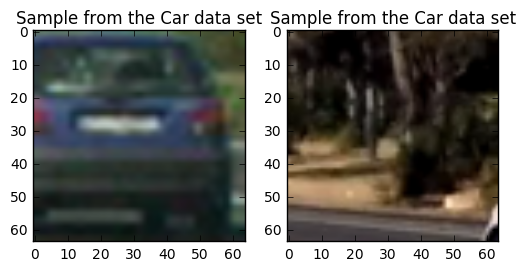

In [2]:
# __ STEP 1  __ Extracting the path of the two data sets: vehicles and non-vechicles
path_images_cars = glob.glob('vehicles/*/*.png')
cars = []
notcars = []
for image in path_images_cars:
    cars.append(image)

path_images_notcars = glob.glob('non-vehicles/*/*.png')
for image in path_images_notcars:
    notcars.append(image)

# Rendering one image from each set for testing    
cars_sample=randint(0,len(cars))
notcars_sample=randint(0, len(notcars))
print ("vector cars is:", len(cars))
print ("non cars is:", len(notcars))
print ("random cars_sample cars is:", cars_sample)
print ("random nonnotcars_samplecars is:", notcars_sample)



# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
img = plt.imread(cars[cars_sample])
plt.imshow(img)
plt.title('Sample from the Car data set')
plt.subplot(122)
img = plt.imread(notcars[notcars_sample])
plt.imshow(img)
plt.title('Sample from the Car data set')
plt.show()
      

    

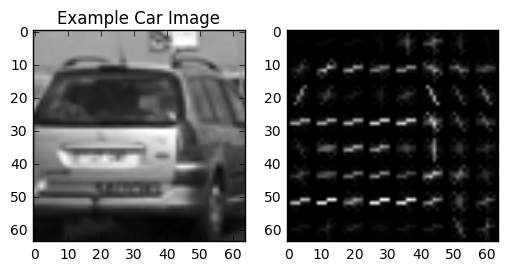

In [20]:
# Extractingthe features
# Cell __ STEP 2  __

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


#Parameters for the features extraction 

color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 680] # Min and max in y to search in slide_window()



# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.show()
plt.title('HOG Visualization')


In [ ]:
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
#sample_size = 2000
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

t=time.time() # counting time start
car_features = extract_features(cars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time() # counting time stop
print(round(t2-t, 2), 'Seconds to extract HOG features...')


print ("cars is length:",len(cars))
print ("notcars is length",len(notcars))
print ("number of features", len(car_features))
print (" number of features",len(notcar_features))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    
    plt.title('Original Image')
    plt.subplot(132)
   
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
   
    plt.title('Normalized Features')
    #plt.show()
    fig.tight_layout()
    plt.show()
else: 
    print('Your function only returns empty feature vectors...')

print(notcar_features[2].shape, notcar_features[0].shape, notcar_features[1].shape)

In [10]:
# Cell __ STEP 3 __

# Create an array stack of feature vectors
#X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('TRAIN Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('TEST Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 30
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# save the model to disk
filename = 'model_color_hog.sav'
pickle.dump(svc, open(filename, 'wb'))
filename = 'save_scaler.sav'
pickle.dump(X_scaler, open(filename, 'wb'))



('Using:', 9, 'orientations', 8, 'pixels per cell and', 2, 'cells per block')
('Feature vector length:', 4932)
(11.38, 'Seconds to train SVC...')
('TRAIN Accuracy of SVC = ', 1.0)
('TEST Accuracy of SVC = ', 0.9817)
('My SVC predicts: ', array([ 0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.]))
('For these', 30, 'labels: ', array([ 0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
        0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.]))
(0.00226, 'Seconds to predict', 30, 'labels with SVC')


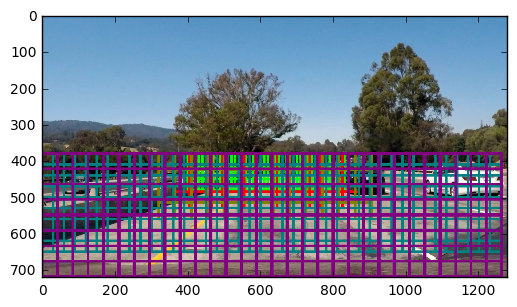

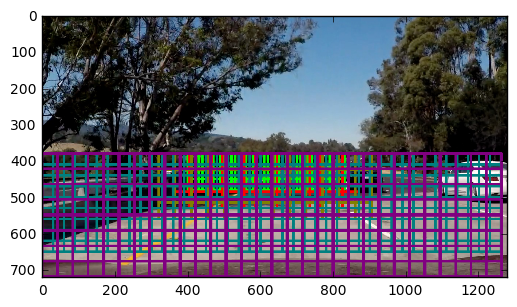

In [11]:
# Cell __STEP 4__ extracting windows froma  single image
from library_classifier import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



image_test1 = mpimg.imread('test1.jpg')
image_test5 = mpimg.imread('test5.jpg')
test_images = []
test_images.append(np.copy(image_test1))
test_images.append(np.copy(image_test5))

#defining regions of interest and size of boxes to look for recognitions
scales = [(40,40), (60,60), (90,90), (120,120), (170,170)]
overlaps = [0.25, 0.25, 0.5, 0.75, 0.75]
y_stops = [500, 550, 600, 650, None]
x_start_stops = [[400,850], [360,890], [320,930], [None, None], [None, None]]
colors = [(0,255,0), (255,0,0), (128,128,0), (0,128,128), (128,0,128)]

result_image = []
for image in test_images:
    possible_windows = np.copy(image)
    for scale, overlap, color, y_stop, x_start_stop in zip(scales, overlaps, colors, y_stops, x_start_stops):

        windows = slide_window(possible_windows, x_start_stop=x_start_stop, y_start_stop=[380,y_stop],
                                   xy_window=scale, xy_overlap=(overlap, overlap))

        possible_windows = draw_boxes(possible_windows, windows, color=color, thick=6) 

    result_image.append((np.copy(possible_windows)))

# Plot the test images
for i in range(len(result_image)):
    imgplot = plt.imshow(result_image[i])
    plt.show()
      


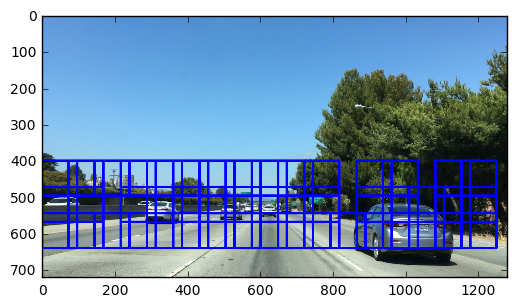

In [14]:
# In this step we try to identify using features the various cars in the image
### TODO: Tweak these parameters and see how the results change.
from library_classifier import *

# load SVM model
svc = pickle.load(open('model_color_hog.sav', 'rb'))

# load scaler
X_scaler = pickle.load(open('save_scaler.sav', 'rb'))

color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 2 # Can be 0, 1, 2, or "ALL"
spatial_size = (40, 40) # Spatial binning dimensions
hist_bins = 44    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 680] # Min and max in y to search in slide_window()


image = mpimg.imread('bbox-example-image.jpg')
draw_image = np.copy(image)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()


('size of cars_files', 8792)
('size of notcars_files', 8968)
('size of Car', 1000)
('size of notcars', 1000)
(' size car features is', 1000)
(' size notcar_features features is', 1000)
(' size scaled_X features is', 2000)
('Using:', 9, 'orientations', 8, 'pixels per cell and', 2, 'cells per block')
('Feature vector length:', 4932)
(0.3, 'Seconds to train SVC...')
('Test Accuracy of SVC = ', 1.0)


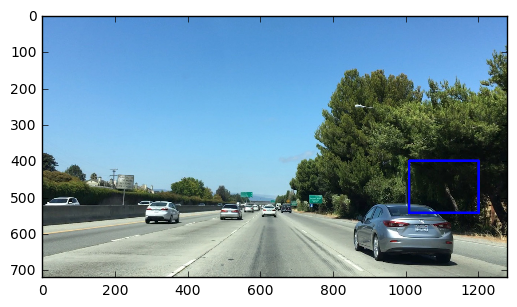

In [14]:
from library_classifier import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 2 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 680] # Min and max in y to search in slide_window()



    
# Read in cars and notcars

cars = []
notcars = []


cars_files = glob.glob('vehicles/*/*.png')
notcars_files = glob.glob('non-vehicles/*/*.png')
    
print ("size of cars_files", len(cars_files))
print ("size of notcars_files", len(notcars_files))


# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
#sample_size = 1000
#cars = cars_files[0:sample_size]
#notcars = notcars_files[0:sample_size]

print ("size of Car", len(cars))
print ("size of notcars", len(notcars))

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print (" size car features is", len(car_features))
print (" size notcar_features features is", len(notcar_features))

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
print (" size scaled_X features is", len(scaled_X))

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('bbox-example-image.jpg')
draw_image = np.copy(image)

classified_images = []


# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 2 # Can be 0, 1, 2, or "ALL"
spatial_size = (40, 40) # Spatial binning dimensions
hist_bins = 44    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 680] # Min and max in y to search in slide_window()

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

heatmap_images = []
labels_images = []
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat,hot_windows)
    
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

heat = apply_threshold(heat,1)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
heatmap_images.append((heatmap))
labels_images.append((draw_img))

plt.imshow(draw_img)
plt.show()



In [15]:
def pipeline(file, output_dir, save_inter, svc, scaler, filepath):

    if filepath == True:
        print("processing : {}".format(file))
        img = cv2.imread(file)
        image_name = os.path.split(file)[-1]
    else :
        img = file
        image_name = 'video'
    # load SVM model
    svc = pickle.load(open('model_color_hog.sav', 'rb'))

    # load scaler
    #X_scaler = pickle.load(open('save_scaler.sav', 'rb'))

    # ################## SETTINGS PIPELINE ################################
    scales = [(64, 64), (96, 96), (128, 128)]
    overlaps = [0.75, 0.75, 0.75]
    y_start_stops = [[400, 500], [400, 500], [400, 600]]
    x_start_stops = [[None, None], [None, None], [None, None]]
    colors = [(255, 0, 0), (128, 128, 0), (0, 128, 128)]
    # #####################################################################

    # ################## SETTINGS CLASSIFIER ##############################
    color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 2 # Can be 0, 1, 2, or "ALL"
    spatial_size = (40, 40) # Spatial binning dimensions
    hist_bins = 44    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [400, 680] # Min and max in y to search in slide_window()

    # #####################################################################

    heat = np.zeros_like(img[:, :, 0]).astype(np.uint8)
    windowed_image = np.copy(img)
    hot_windowed_image = np.copy(img)
    #heat = np.zeros_like(img[:, :, 0]).astype(np.uint8)
    #heat = np.zeros_like(image[:,:,0]).astype(np.float)


    # STEP 1 : compute the sliding windows
    for scale, overlap, color, y_start_stop, x_start_stop in zip(scales, overlaps, colors, y_start_stops, x_start_stops):
        
        windows = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                               xy_window=scale, xy_overlap=(overlap, overlap))

        # STEP 2 : Apply classifier on current windows
        
        hot_windows = search_windows(img, windows, svc, scaler=X_scaler, color_space=color_space,
                                     spatial_size=spatial_size, hist_bins=hist_bins,
                                     orient=orient, pix_per_cell=pix_per_cell,
                                     cell_per_block=cell_per_block,
                                     hog_channel=hog_channel, spatial_feat=spatial_feat,
                                     hist_feat=hist_feat, hog_feat=hog_feat)
        
        
        # STEP 3 : Compute/Update HeatMap
        heat = add_heat(heat, hot_windows)

        if save_inter:
            # Update windowed images
    # STEP 4 : Apply Threshold on HeatMap and map values to [0, 255]
    heat = apply_threshold(heat, 2)
    heatmap = np.clip(heat, 0, 255)
    if save_inter:
       cv2.imwrite(os.path.join(output_dir, 'heatmap_' + image_name), heatmap)

    # STEP 5 : Determine bounding boxes and draw on images
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

In [16]:
from moviepy.editor import VideoFileClip

start = time.time()

#load the models
svc = pickle.load(open('model_color_hog.sav', 'rb'))
# load scaler
X_scaler = pickle.load(open('save_scaler.sav', 'rb'))

file="project_video.mp4"

def create_image_pipeline(svc, scaler):
        def image_pipeline(file):
            return pipeline(file, None, False, svc, scaler, filepath=False)
        return image_pipeline

image_pipeline = create_image_pipeline(svc, X_scaler)

# load input_video
clip1 = VideoFileClip("project_video.mp4")

# apply the pipeline to the video
output_clip = clip1.fl_image(image_pipeline)

# save the new video
output_video ="result_video.mp4"
output_clip.write_videofile(output_video, audio=False)

print("\nScript took {} seconds\n\n".format(time.time() - start))


[MoviePy] >>>> Building video result_video.mp4
[MoviePy] Writing video result_video.mp4


100%|█████████▉| 1260/1261 [05:28<00:00,  4.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_video.mp4 


Script took 330.029772043 seconds


